# <center>네이버 영화리뷰 감성분석 도전하기</center>

이전 스텝까지는 영문 텍스트의 감정 분석을 진행해 보았습니다. 그렇다면 이번에는 한국어 텍스트의 감정 분석을 진행해 보면 어떨까요? 오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.

```
/Documents/projects/Aiffel/lms/projects/data/proj_8/*.txt
```

In [3]:
import pandas as pd
import konlpy
import matplotlib.pyplot as plt
import gensim
import numpy as np 
import seaborn as sns

print(np.__version__)
print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.23.5
1.4.2
0.6.0
4.2.0


### 1) 데이터 준비와 확인

In [63]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/Documents/projects/Aiffel/lms/projects/data/proj_8/naver_review_ratings_train.txt')
test_data = pd.read_table('~/Documents/projects/Aiffel/lms/projects/data/proj_8/naver_review_ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0.0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1.0
2,10265843,너무재밓었다그래서보는것을추천한다,0.0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0.0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1.0


In [64]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [65]:
print(train_data.shape, test_data.shape)

(85784, 3) (50000, 3)


In [66]:
train_data['str_len'] = train_data['document'].str.len()

### 2) 데이터로더 구성
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

데이터의 중복 제거
NaN 결측치 제거
한국어 토크나이저로 토큰화
불용어(Stopwords) 제거
사전word_to_index 구성
텍스트 스트링을 사전 인덱스 스트링으로 변환
X_train, y_train, X_test, y_test, word_to_index 리턴


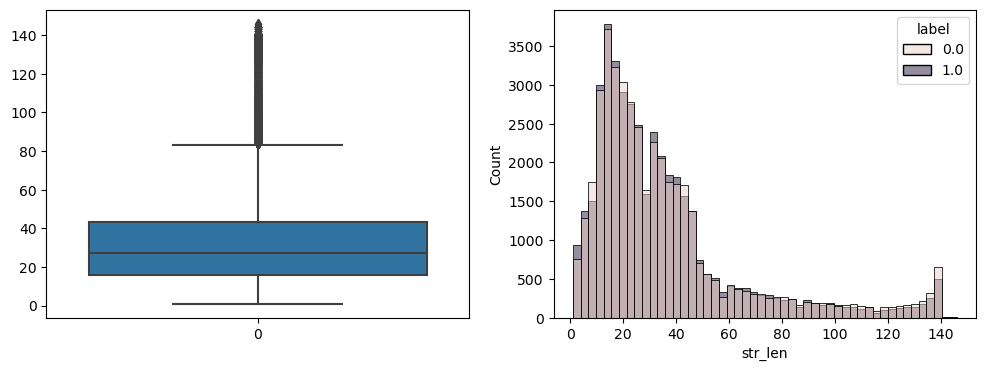

In [67]:
# sns.lineplot(x = train_data.index, y = train_data['document'].str.len())
fig, axes = plt.subplots(1,2, figsize = (12,4))
sns.boxplot(sorted(train_data['document'].str.len()), ax = axes[0])
sns.histplot(data = train_data, x = 'str_len', bins = 50, ax = axes[1], hue='label')
plt.show()

In [68]:
print(train_data['document'].str.len().describe())
train_data['label'].value_counts()

count    85782.000000
mean        35.306778
std         29.602170
min          1.000000
25%         16.000000
50%         27.000000
75%         43.000000
max        146.000000
Name: document, dtype: float64


0.0    42976
1.0    42807
Name: label, dtype: int64

In [69]:
print("train_data 전체 자료수: ", len(train_data))
print(" 중복이 없는 document data: ",len(set(train_data['document'])), "\n", \
    "중복없는 id:", len(set(train_data['id'])), "\n",\
    "중복된 document data: ", train_data['document'].duplicated().sum())


train_data 전체 자료수:  85784
 중복이 없는 document data:  83949 
 중복없는 id: 85784 
 중복된 document data:  1835


- id에는 중복이 없으나, 글 내용이 같은 데이터가 약 1,835개가 존재하는 것으로 확인됨

- 구체적으로 어떤 글들이 중복되었는지 확인

In [70]:
print(train_data['document'][train_data['document'].duplicated()])

1058                                                     4
1097                                                    쵝오
1248                                                    최고
1483                                                    최고
1707                                                   재밌다
                               ...                        
85599                                                 멋집니다
85673    나는 희망한다. 나의 꿈을... 영화는 나에게 알게해줬다! 나의 마음속에 담겨져 있...
85680                                                   굿굿
85747                                                 좋아요.
85764                                                  ...
Name: document, Length: 1835, dtype: object


- 전체적으로 최고, 쵝오, 재밌다, 굿굿 등 짧은 글들이 많이 중복되어 있는 것을 보임. 따라서 이들이 평점상으로는 의미가 있는 것으로 판단되며, 만약에 꽤 긴 글이 중복되었다면 이는 다른 아이디로 같은 내용을 두 번쓴 것으로 판단할 수 있을 것으로 보임.

In [71]:
train_data['document'][train_data.index[train_data['document'].duplicated()] & train_data.index[train_data['document'].str.len() >= 10]]

/var/folders/l5/xccndwgd1qd4v2sfh261kbpm0000gn/T/ipykernel_69215/382785877.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  train_data['document'][train_data.index[train_data['document'].duplicated()] & train_data.index[train_data['document'].str.len() >= 10]]


4045                             물체가 움직이거나 어떤 일이 진행되는 빠르기.
6402                                       tv 전기세가 아까웠다!!!
6623                             물체가 움직이거나 어떤 일이 진행되는 빠르기.
7353                                            더럽게 재미없다..
7617                                          마음이 따뜻해지는 영화
                               ...                        
84340                                       tv 전기세가 아깝다!!!
84781                                       tv 전기세가 아깝다!!!
84982    세계관이니 이해력의 문제가 아니다. 애초에 철학없이 그럴싸 한것만 나열해 놓구선, ...
85081                                           더럽게 재미없다..
85673    나는 희망한다. 나의 꿈을... 영화는 나에게 알게해줬다! 나의 마음속에 담겨져 있...
Name: document, Length: 205, dtype: object

- 글자수를 1부터 하나씩 올려가면서 직접 확인 결과 10글자 이상되는 글 중에 중복되는 것은 쉽게 겹치기 어려운 부분이라고 판단. 205개의 데이터는 제외하기로 결정함.

In [72]:
index = train_data.index[train_data.index[train_data['document'].duplicated()] & train_data.index[train_data['document'].str.len() >= 10]]
train_data.loc[index,:]

/var/folders/l5/xccndwgd1qd4v2sfh261kbpm0000gn/T/ipykernel_69215/2078512671.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  index = train_data.index[train_data.index[train_data['document'].duplicated()] & train_data.index[train_data['document'].str.len() >= 10]]


,id,document,label,str_len
4045,9297134,물체가 움직이거나 어떤 일이 진행되는 빠르기.,0.0,25.0
6402,8849139,tv 전기세가 아까웠다!!!,0.0,15.0
6623,9576197,물체가 움직이거나 어떤 일이 진행되는 빠르기.,0.0,25.0
7353,6763280,더럽게 재미없다..,0.0,10.0
7617,587411,마음이 따뜻해지는 영화,1.0,12.0
...,...,...,...,...
84340,8769379,tv 전기세가 아깝다!!!,0.0,14.0
84781,8190719,tv 전기세가 아깝다!!!,0.0,14.0
84982,8984868,"세계관이니 이해력의 문제가 아니다. 애초에 철학없이 그럴싸 한것만 나열해 놓구선, ...",0.0,75.0
85081,7485308,더럽게 재미없다..,0.0,10.0


In [4]:
def subset_duplicated(df_data):
    indices = df_data.index[df_data.index[df_data['document'].duplicated()] & df_data.index[df_data['document'].str.len() >= 10]]
    return df_data.drop(index = indices)

def remove_nan(df_data):
    null_index = df_data.index[df_data['document'].isnull()]
    return df_data.drop(index = null_index)


In [24]:
from konlpy.tag import Mecab
from collections import Counter
from sklearn.model_selection import train_test_split

tokenizer = Mecab()
test = " 어떻게 되나 한 번 만들어 봅시다. test"
tokenizer.morphs(test)

ModuleNotFoundError: No module named 'tensorflow'

In [110]:
# emoji 참고: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
import re

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r"[a-zA-Z]+", " ", sentence)
    sentence = re.sub(r"[ㄱ-ㅎㅏ-ㅣ]+", " ", sentence) # 4
    sentence = re.sub(r"\d+", " ", sentence) # 4
    sentence = re.sub("\.|\,|\-|\~|\!|\?", "", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = sentence.strip() # 5
    return sentence
    
print(train_data['document'][0])
preprocess_sentence('아 더빙.. 진짜 짜증나네요 목소리 kkk ㅏㅏㅏ ㅇㅇㅇ ~.,!? ... 12342 ㅗㅗㅗ')

아 더빙 진짜 짜증나네요 목소리


'아 더빙 진짜 짜증나네요 목소리'

In [107]:
for i in range(len(train_data['document'])):
    train_data['document'][i] = preprocess_sentence(str(train_data['document'][i]))

for j in range(len(test_data['document'])):
    test_data['document'][j] = preprocess_sentence(str(test_data['document'][j]))


/var/folders/l5/xccndwgd1qd4v2sfh261kbpm0000gn/T/ipykernel_69215/2519608704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['document'][i] = preprocess_sentence(str(train_data['document'][i]))
/var/folders/l5/xccndwgd1qd4v2sfh261kbpm0000gn/T/ipykernel_69215/2519608704.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['document'][j] = preprocess_sentence(str(test_data['document'][j]))


In [108]:
print(train_data.head(), train_data.tail())
print(test_data.head(), test_data.tail())

         id                                           document  label  str_len
0   9976970                                  아 더빙 진짜 짜증나네요 목소리    0.0     19.0
1   3819312                       흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나    1.0     33.0
2  10265843                                  너무재밓었다그래서보는것을추천한다    0.0     17.0
3   9045019                         교도소 이야기구먼 솔직히 재미는 없다 평점 조정    0.0     29.0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...    1.0     61.0             id                                           document  label  \
85779  9922230                            김새론 연기 정말 잘하는구나 정말 슬픈영화    1.0   
85780  7252911  남자의 순수한 사랑은 그럭저럭 괜찮지만 이를 받아드리는 여자가 생각만큼 이해되지 않...    0.0   
85781  1086892                       어설픈 소재부터 마음에 안들더니 공포감도 안느껴진다    0.0   
85782  8044826  와 연기력 연출 스토리 다 개판이네 정우 연기가 많이 늘었다고 새삼 느끼게된 영화 ...    0.0   
85783  8859119                                                  흑    NaN   

       str_len  
85779     24.0  
85780     91.0  
85781     28.0  
8

In [111]:
train_data.to_pickle('./data/proj_8/230112_train_data.pkl')
test_data.to_pickle('./data/proj_8/230112_test_data.pkl')

In [6]:
train_data = pd.read_pickle('./data/proj_8/230112_train_data.pkl')
test_data = pd.read_pickle('./data/proj_8/230112_test_data.pkl')

In [18]:
total_data_text = list(train_data['document']) + list(test_data['document'])
token_len_lst = [len(tokens.split()) for tokens in total_data_text]

num_tokens = np.array(token_len_lst)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  7.738282861014553
문장길이 최대 :  42
문장길이 표준편차 :  6.684278717158282
pad_sequences maxlen :  21
전체 문장의 0.9386083780121369%가 maxlen 설정값 이내에 포함됩니다. 


In [19]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:

def load_data(train_data, test_data, stopwords, max_len):
    tokenizer = Mecab()
    #1. 데이터 중복 제거
        # - 데이터 확인 결과 id 값은 중복이 없으나, 리뷰 내용은 중복이 있는 것으로 판단
        # - 그러나 최고, 쵝오, 굿굿, 좋아요 등 짧은 내용의 중복이 많아 이 경우 반드시 같은 사람이 중복으로 썼을 것인가에 대한 판단이 어려움
        # - 길이가 10이상인데도 불구하고 같은 리뷰가 있다면, 단순 복사 붙여넣기 인 것으로 판단하여 제거하기로 결정.
    df_train_data = subset_duplicated(train_data)
    df_test_data = subset_duplicated(test_data)
    #2. NaN 결측치 제거
    df_train_data = remove_nan(df_train_data)
    df_test_data = remove_nan(df_test_data)

    df_train_data = df_train_data.reset_index
    df_test_data = df_test_data.reset_index
    #3. tokenize
    corpus = " ".join(train_data['document'].to_list()) + " ".join(test_data['document'].to_list())
    tokens = tokenizer.morphs(corpus)
    #4. Stopwords제거 사전
    for sentence_i in range(len(df_train_data['document'])): 
        result = [] 
        tokens = tokenizer.morphs(df_train_data['document'][sentence_i])
        for w in tokens:
            if w not in stopwords: 
                result.append(w) 
        df_train_data['document'][sentence_i] = " ".join(result)
    
    for sentence_j in range(len(df_test_data['document'])): 
        result = [] 
        tokens = tokenizer.morphs(df_test_data['document'][sentence_j])
        for w in tokens:
            if w not in stopwords: 
                result.append(w) 
        df_test_data['document'][sentence_j] = " ".join(result)
    
    #4. word_to_index구성텍스트 스트링을 사전인덱스 스트링으로 변환
    unique_tokens = set(tokens)
    index_to_word = {}
    index_to_word[0] = '<PAD>'
    index_to_word[1] = '<BOS>'
    index_to_word[2] = '<UNK>'
    for i in range(3,len(unique_tokens)):
        index_to_word[i] = unique_tokens[i]
    word_to_index = {word:index for index, word in index_to_word.items()}    
            
    #5. 데이터 split(X_train, y_train, X_test, y_test)
    X_train = df_train_data['document']
    X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                            value=word_to_index["<PAD>"],
                                                            padding='pre', # 혹은 'post'
                                                            maxlen=maxlen)

    X_test = df_test_data['document']
    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

    
    y_train = df_train_data['label']
    y_test = df_test_data['label']

    return X_train, y_train, X_test, y_test, word_to_index

stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, stopwords, max_len)

/var/folders/l5/xccndwgd1qd4v2sfh261kbpm0000gn/T/ipykernel_73506/3481007976.py:2: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  indices = df_data.index[df_data.index[df_data['document'].duplicated()] & df_data.index[df_data['document'].str.len() >= 10]]


TypeError: 'method' object is not subscriptable

3) 모델 구성을 위한 데이터 분석 및 가공
데이터셋 내 문장 길이 분포
적절한 최대 문장 길이 지정
keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


4) 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.



5) 모델 훈련 개시


6) Loss, Accuracy 그래프 시각화


7) 학습된 Embedding 레이어 분석


8) 한국어 Word2Vec 임베딩 활용하여 성능 개선


한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. 
- [참고 링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models)
- [참고 링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)

```python
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv
```
[‘끝’]